# Behavioral Cloning

This notebook contains the implementation of CNN used for Behavioral cloning project.

In [1]:
import csv
import cv2
import numpy as np
import os
import sklearn
from sklearn.utils import shuffle


Define a function for image augmenting.

In [2]:
def process_image(img):
    
    return img, cv2.flip(img, 1)

Iterate over driving log data:

In [3]:
import os
import csv

samples = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)


Split the samples into training and validation set:

In [4]:
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(samples, test_size=0.2, shuffle=True, random_state=42)

Define data generator. For each batch item, this will actually generate 6 distinct images:

In [5]:
correction = 0.2 # this is a parameter to tune

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                steering_c = float(batch_sample[3])        
                steering_l = steering_c + correction
                steering_r = steering_c - correction
    
                path = './data/IMG/' 
            
                img_c, img_cf = process_image(cv2.imread(path + batch_sample[0].split('\\')[-1]))
                img_l, img_lf = process_image(cv2.imread(path + batch_sample[1].split('\\')[-1]))
                img_r, img_rf = process_image(cv2.imread(path + batch_sample[2].split('\\')[-1]))

                images.extend([img_c, img_cf, img_l, img_lf, img_r, img_rf])
                angles.extend([steering_c, -steering_c, steering_l, -steering_l, steering_r, -steering_r])

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

Define train and validation generators:

In [6]:
# Set our batch size
batch_size=8

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

Actual CNN implementation:

In [7]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, AveragePooling2D, Cropping2D, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow
from math import ceil

# dropout rate
dropout_rate = 0.25

model = Sequential()
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: (x / 255.0) - 0.5))
model.add(Conv2D(filters=24, 
                 kernel_size=(5, 5), 
                 strides=(2,2), 
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.0001)))
model.add(Conv2D(filters=36, 
                 kernel_size=(5, 5), 
                 strides=(2,2), 
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.0001)))
model.add(Conv2D(filters=48, 
                 kernel_size=(5, 5), 
                 strides=(2,2), 
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.0001)))
model.add(Conv2D(filters=64, 
                 kernel_size=(3, 3), 
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.0001)))
model.add(Conv2D(filters=64, 
                 kernel_size=(3, 3), 
                 activation='relu',
                 kernel_regularizer=regularizers.l2(0.0001)))
model.add(Flatten())
model.add(Dense(units=1164, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(units=10, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1))


early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
mcp_save = ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5', save_best_only=True, monitor='val_loss', mode='min')
opt = Adam(learning_rate=0.001)

model.compile(loss='mse', optimizer=opt)
history_object = model.fit_generator(train_generator, 
                                     steps_per_epoch=ceil(len(train_samples) / batch_size), 
                                     validation_data=validation_generator,
                                     validation_steps=ceil(len(validation_samples) / batch_size), 
                                     epochs=150, 
                                     callbacks=[mcp_save, early_stopping],
                                     verbose=1,
                                     shuffle=True)

model.save('model.h5')

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Epoch 1/150
305/305 [==============================] - 32s 103ms/step - loss: 0.0454 - val_loss: 0.0082
Epoch 2/150
305/305 [==============================] - 26s 87ms/step - loss: 0.0350 - val_loss: 0.0050
Epoch 3/150
305/305 [==============================] - 28s 91ms/step - loss: 0.0334 - val_loss: 0.0034
Epoch 4/150
305/305 [==============================] - 28s 93ms/step - loss: 0.0319 - val_loss: 0.0049
Epoch 5/150
305/305 [==============================] - 28s 91ms/step - loss: 0.0309 - val_loss: 0.0041
Epoch 6/150
305/305 [==============================] - 27s 89ms/step - loss: 0.0304 - val_loss: 0.0035
Epoch 7/150
305/305 [==============================] - 27s 88ms/step - loss: 0.0304 - val_loss: 0.0027
Epoch 8/150
305/305 [==============================] - 29s 94ms/step - loss: 0.0299 - val_loss: 0.0019
Epoch 9/150
305/305 [==============================] - 28s 90ms/step - loss: 0.0292 - val_los

dict_keys(['val_loss', 'loss'])


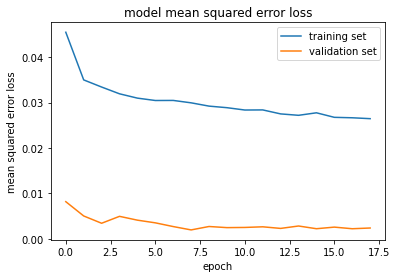

In [8]:
import matplotlib.pyplot as plt

print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()